## C S 329E HW 6

# KNN 

## Michel Gonzalez - mag9989

For this week's homework we are going explore one new classification technique:

  - k nearest neighbors

We are using a different version of the Melbourne housing data set, to predict the housing type as one of three possible categories:

  - 'h' house
  - 'u' duplex
  - 't' townhouse

At the end of this homework, I expect you to understand how to build and use a kNN model, and practice your data cleaning and data preparation skills. 

In [1]:
# These are the libraries you will use for this assignment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import calendar
%matplotlib inline

# Starting off loading a training set
df_melb = pd.read_csv('https://gist.githubusercontent.com/yanyanzheng96/81b236aecee57f6cf65e60afd865d2bb/raw/56ddb53aa90c26ab1bdbfd0b8d8229c8d08ce45a/melb_data_train.csv')

## Q1 - Fix a column of data to be numeric
If we inspect our dataframe, `df_melb` using the `dtypes` method, we see that the column "Date" is an object.  However, we think this column might contain useful information so we want to convert it to [seconds since epoch](https://en.wikipedia.org/wiki/Unix_time). Use only the exiting imported libraries to create a new column "unixtime". Be careful, the date strings in the file might have some non-uniform formatting that you have to fix first.  Print out the min and max epoch time to check your work.  Drop the original "Date" column. Please use the python [reference for time](https://docs.python.org/3/library/time.html) to help you do the string to Unix time conversion. 

In [2]:
# normalize date accepts the date string as shown in the df_melb 'Date' column,
# and returns a data in a standarized format
def standardize_date(d):
    # Your code here

    # since the d varies bewtween two formats
    # 'D/M/YY' or 'DD/MM/YYYY', the longer fomrat
    # has a length of 10 so I split the formating fucntion
    # into the two cases
    if(len(d) < 10):
      
      standard = time.strptime(d, '%d/%m/%y')

    else:

      standard = time.strptime(d, '%d/%m/%Y')

    return standard

In [3]:
# Transoforms the 'Date' column so all dates have the smae format 'DD/MM/YYYY'
# next we take that new formatted date column and  convert it to seconds since epoch
df_melb['Date'] = df_melb['Date'].apply( lambda x : standardize_date(x)) 

df_melb['unixtime'] = df_melb['Date'].apply( lambda x : int(time.mktime(x)))

df_melb = df_melb.drop(columns="Date")

print("The min unixtime is {:d} and the max unixtime is {:d}".format(df_melb['unixtime'].min(),df_melb['unixtime'].max()))

The min unixtime is 1454544000 and the max unixtime is 1506124800


## Q2 Use Imputation to fill in missing values
kNN doesn't work when the attributes are not valid for all of the attribute columns, so fill in all the missing values in `df_melb` with the mean of that column.  Save the mean of each column in a dictionary, `dict_imputation`, whose key is the attribute column name, so we can apply the same imputation to the test set later. Show your `dict_imputation` dictionary and the head of your `df_melb` dataframe.  The target classfication (aka the class label) is stored in the column `'Type'`, so we are going to define a variable target_col so we can reference the target_col using a variable. (hint: during imputation you skip the target column)

In [4]:
target_col = 'Type'

In [5]:
dict_imputation = dict()

# Gets each mean of all the coulumns exxcept our target
# and stores it into a dictionary
for col in df_melb.columns:
    # your code here

    if (col == target_col):

      continue

    else:
      
      dict_imputation[col] = np.mean(df_melb[col])

In [6]:
dict_imputation

{'Bathroom': 1.44,
 'BuildingArea': 121.7832,
 'Car': 1.503006012024048,
 'Distance': 10.524599999999985,
 'Landsize': 638.91,
 'Postcode': 3113.122,
 'Price': 932558.7,
 'Rooms': 2.71,
 'YearBuilt': 1970.9417475728155,
 'unixtime': 1485178502.4}

In [7]:
# Fills in all NAN values with the approriate mean value
df_melb = df_melb.fillna(value = dict_imputation)

df_melb.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,2,h,399000,8.7,3032,1,1.0,904,53.0000,1985.000000,1462579200
1,3,h,1241000,13.9,3165,1,1.0,643,121.7832,1970.941748,1472342400
2,2,u,550000,3.0,3067,1,1.0,1521,121.7832,1970.941748,1499472000
3,3,u,691000,8.4,3072,1,1.0,170,121.7832,1970.941748,1498262400
4,2,u,657500,4.6,3122,1,1.0,728,73.0000,1965.000000,1479513600


## Q3 Normalize all the attributes to be between [0,1]
Normalize all the attribute columns in `df_melb` so they have a value between zero and one (inclusive). Save the (min,max) tuple used to normalize to a dictionary, `dict_normalize`, so we can apply it to the test set later.  The dataframe `df_melb` is now your "model" that you can use to classify new data points. (hint: during normalization you skip the class label column)

In [8]:
# normalize: z = (x - min(x))/ max(x) - min(x)
dict_normalize = dict()

# normalizes by columns 
# and stores the max and min for
# each column as a tuple
for col in df_melb.columns:
    # your code here

    if (col == target_col):

      continue

    else:
      
      min_max = (min(df_melb[col]), max(df_melb[col]))

      dict_normalize[col] = min_max

      df_melb[col] = df_melb[col].apply( lambda x : (x - min_max[0])/(min_max[1] - min_max[0]))



In [9]:
dict_normalize

{'Bathroom': (0, 4),
 'BuildingArea': (0.0, 475.0),
 'Car': (0.0, 4.0),
 'Distance': (0.7, 47.3),
 'Landsize': (0, 41400),
 'Postcode': (3002, 3810),
 'Price': (291000, 5020000),
 'Rooms': (1, 6),
 'YearBuilt': (1890.0, 2015.0),
 'unixtime': (1454544000, 1506124800)}

In [10]:
df_melb.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,0.2,h,0.022838,0.171674,0.037129,0.25,0.25,0.021836,0.111579,0.760000,0.155779
1,0.4,h,0.200888,0.283262,0.201733,0.25,0.25,0.015531,0.256386,0.647534,0.345059
2,0.2,u,0.054768,0.049356,0.080446,0.25,0.25,0.036739,0.256386,0.647534,0.871022
3,0.4,u,0.084584,0.165236,0.086634,0.25,0.25,0.004106,0.256386,0.647534,0.847571
4,0.2,u,0.077501,0.083691,0.148515,0.25,0.25,0.017585,0.153684,0.600000,0.484087


## Q4 Load in the Test data and prep it for classification
Everything we did to our "train" set, we need to now do in our "test" set. 

In [11]:
df_test = pd.read_csv('https://gist.githubusercontent.com/yanyanzheng96/c3d53303cebbd986b166591d19254bac/raw/94eb3b2d500d5f7bbc0441a8419cd855349d5d8e/melb_data_test.csv')

In [12]:
# Your code here to fix date

df_test['Date'] = df_test['Date'].apply( lambda x : standardize_date(x)) 

df_test['unixtime'] = df_test['Date'].apply( lambda x : int(time.mktime(x)))

df_test = df_test.drop(columns="Date")

print("The min unixtime is {:d} and the max unixtime is {:d}".format(df_test['unixtime'].min(),df_test['unixtime'].max()))

The min unixtime is 1454544000 and the max unixtime is 1506124800


In [13]:
# Your code here for imputation - must use dictionary from above!

df_test = df_test.fillna(value = dict_imputation)

df_test.head()        

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,3,h,1116000,17.9,3192,1,2.0,610,121.7832,1970.941748,1498867200
1,3,h,2030000,11.2,3186,2,2.0,366,121.7832,1970.941748,1472342400
2,3,h,1480000,10.7,3187,2,2.0,697,143.0000,1925.000000,1478476800
3,3,u,1203500,12.3,3166,2,2.0,311,127.0000,2000.000000,1495843200
4,3,h,540000,14.7,3030,2,2.0,353,135.0000,2011.000000,1504396800


In [14]:
# Your code here for scaling - must use dictionary from above!
for col in df_test.columns:
    # your code here

    if (col == target_col):

      continue

    else:

      df_test[col] = df_test[col].apply( lambda x : (x - dict_normalize[col][0])/(dict_normalize[col][1] - dict_normalize[col][0]))

df_test.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,0.4,h,0.174455,0.369099,0.235149,0.25,0.5,0.014734,0.256386,0.647534,0.859296
1,0.4,h,0.367731,0.225322,0.227723,0.50,0.5,0.008841,0.256386,0.647534,0.345059
2,0.4,h,0.251427,0.214592,0.228960,0.50,0.5,0.016836,0.301053,0.280000,0.463987
3,0.4,u,0.192958,0.248927,0.202970,0.50,0.5,0.007512,0.267368,0.880000,0.800670
4,0.4,h,0.052654,0.300429,0.034653,0.50,0.5,0.008527,0.284211,0.968000,0.966499


Q5 Write the kNN classifier function
Your function `knn_class`, should take five parameters, the training dataframe (that includes the target column), the hyper parameter `k`, the name of the target column, a single observation row (a series or attributes the same length as the attributes in `df_train`) of the test dataframe, and a boolean `use_weighted_vote`.  When `use_weighted_vote` is set to true, use weighted voting, otherwise use majority voting. We are assuming that the parameter `df_train` contains all of the attributes, and the target class in the same dataframe. The function returns the predicted target classification for that observation. To find the distance between the single observation and the training data frame you should use the [L2 norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html)

In [15]:
def knn_class(df_train, k, target_col, observation, use_weighted_vote ):
   # your code here

   # Gets the distances between the observation
   # and all the other traning observations in the dataframe

  # gets the target data
   target = df_train[target_col]

   # creates a data frame to manipulate and find both
   # the distances (2-norm) and the weights (1/(distance)^2)

   df_manipulate = df_train.drop(columns = target_col)

   df_manipulate['distances'] = (df_manipulate - observation).apply(np.linalg.norm, axis = 1)

   df_manipulate['weights'] = 1/(df_manipulate['distances'] * df_manipulate['distances'])

   df_sort = df_manipulate[['distances', 'weights']]

   df_sort[target_col] = target

   # sorts the dataframe wiht the smallest distances first
   # thus the heaviest points will be fisrt as well
   df_sort = df_sort.sort_values(by = 'distances')

   # slices the data frame into the k
   # values we are going to train on
   df_sort = df_sort[0:k]

   # used for weighted voting 
   classes = df_sort[target_col].unique()

   sums = []

   # The tie breaker for majority vote is that it
   # will pick the first most frequent value
   if (use_weighted_vote == False):

     return df_sort[target_col].value_counts().index[0]

   # The tie breaker for weighted voting is that it
   # will pick the first maximum it finds
   else:

     df_sort[target_col] = target

     for l in classes:
       
       total = df_sort[df_sort[target_col] == l]['weights'].sum()

       sums.append(total)

     return classes[np.argmax(sums)]

## Q6 Compute the accuracy using different k values
For each value of $k$ in the set $\{1,3,13,25,50,100\}$ calculate the class prediction for each oberservation in the test set, and the overall accuracy of the classifier.  Plot the accuracy as a function of $k$ when `use_weighted_vote` is `True` and when `use_weighted_vote` is `False`.

Which value of $k$ would you chose, and would you use weighted voting or majority voting?

Note, this took 20 seconds for me on Google Colab. 

In [16]:
poss_k = [1,3,13,25,50,100] # possible k's
acc_k_majority = list(np.zeros(len(poss_k))) # Accuracy for each value of k using majority voting
acc_k_weighted = list(np.zeros(len(poss_k))) # Accuracy for each value of k using weighted voting

# Ceates the target set from the test to
# see how accurate our model was
actual = df_test[target_col]

# Creates the testing data frame for the observations
# with out the target
df_tester = df_test.drop(columns = target_col)

# Runs through each k and evaluates
# the accuracy from each voting method
for k in poss_k:
  
  # Creates the predicted array for majority voting
  # and finds the accuracy by counting all the values
  # that were predicted correctly then dividing by
  # the totla number of elements in the test data
  predictions_maj = pd.DataFrame(df_tester.apply( lambda x : knn_class(df_melb, k, target_col, x, False), axis = 1), columns = ['Classification'])

  acc_maj = np.array(predictions_maj['Classification'] == actual)

  n_maj = len(predictions_maj)
  
  acc_k_majority[poss_k.index(k)] = (np.count_nonzero(acc_maj == True))/n_maj

  # Creates the predicted array for weighted voting
  # and finds the accuracy by counting all the values
  # that were predicted correctly then dividing by
  # the totla number of elements in the test data
  predictions_wei = pd.DataFrame(df_tester.apply( lambda x : knn_class(df_melb, k, target_col, x, True), axis = 1), columns = ['Classification'])

  acc_wei = np.array(predictions_wei['Classification'] == actual)

  n_wei = len(predictions_wei)

  acc_k_weighted[poss_k.index(k)] = (np.count_nonzero(acc_wei == True))/n_wei
  



In [17]:
# DO NOT GRADE
# this is here for my refrence
# on how I came up with the code above
'''poss_k = [1,3,13,25,50,100] # possible k's
acc_k_majority = list(np.zeros(len(poss_k))) # Accuracy for each value of k using majority voting
acc_k_weighted = list(np.zeros(len(poss_k))) # Accuracy for each value of k using weighted voting

# Your code here

# Ceates the target set from the test to
# see how accurate our model was
actual = df_test[target_col]

# Creates the testing data frame for the observations
# with out the target
df_tester = df_test.drop(columns = target_col)

# Runs through each k and evaluates
# the accuracy from each voting method
for k in poss_k:

  predictions_maj = []

  predictions_wei = []

  # Gets the predicted values for majority votes
  for index, row in df_tester.iterrows():
    
    predictions_maj.append(knn_class(df_melb, k, target_col, row, False))
    
  # Gets the accuracy by creating a boolean array
  # and counting the number of values that == True
  # then dividing that count by the total number
  # of elements
  acc_array_maj = np.array((predictions_maj == actual))

  n_maj = len(predictions_maj)

  count_maj = 0

  for i in range(0, len(acc_array_maj)):
    
    if(acc_array_maj[i] == True):

        count_maj += 1

    else:

        continue
    
  acc_maj = count_maj/n_maj

  acc_k_majority[poss_k.index(k)] = (acc_maj)

  # Gets the predicted values for weighted votes 
  for index, row in df_tester.iterrows():
    
    predictions_wei.append(knn_class(df_melb, k, target_col, row, True))

  # Same methodology as for majority vote accuracy
  acc_array_wei = np.array(predictions_wei == actual)

  n_wei = len(predictions_wei)

  count_wei = 0

  for j in range(0, len(acc_array_wei)):
    
    if(acc_array_wei[j] == True):

        count_wei += 1

    else:

        continue
    
  acc_wei = count_wei/n_wei

  acc_k_weighted[poss_k.index(k)] = (acc_wei)'''

"poss_k = [1,3,13,25,50,100] # possible k's\nacc_k_majority = list(np.zeros(len(poss_k))) # Accuracy for each value of k using majority voting\nacc_k_weighted = list(np.zeros(len(poss_k))) # Accuracy for each value of k using weighted voting\n\n# Your code here\n\n# Ceates the target set from the test to\n# see how accurate our model was\nactual = df_test[target_col]\n\n# Creates the testing data frame for the observations\n# with out the target\ndf_tester = df_test.drop(columns = target_col)\n\n# Runs through each k and evaluates\n# the accuracy from each voting method\nfor k in poss_k:\n\n  predictions_maj = []\n\n  predictions_wei = []\n\n  # Gets the predicted values for majority votes\n  for index, row in df_tester.iterrows():\n    \n    predictions_maj.append(knn_class(df_melb, k, target_col, row, False))\n    \n  # Gets the accuracy by creating a boolean array\n  # and counting the number of values that == True\n  # then dividing that count by the total number\n  # of elements\n

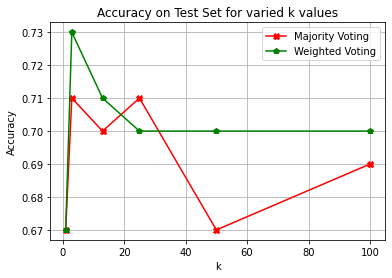

In [18]:
# plot code here

# Plots the accuracy from both voting methods
plt.plot(poss_k, acc_k_majority, '-X', color = 'red', label = 'Majority Voting')

plt.plot(poss_k, acc_k_weighted, '-p', color = 'green', label = 'Weighted Voting')

plt.xlabel('k')

plt.ylabel('Accuracy')

plt.title('Accuracy on Test Set for varied k values')

plt.legend()

plt.grid()

plt.show()



➡️ Based on my analysis the best k to use would be k = 3 and the weighted voting scheme since it did slightly better than majority voting when k = 3.

The other k values have less accuracy in both voting regimes and for the higher k values, they are not optimal since it would increase the compuational cost of traning the model due to more values needing to be voted on.